In [24]:
# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 7)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


In [25]:
# Option 1: Upload file manually in Colab (left sidebar > Files > Upload)
# Then use:
#df = pd.read_csv('ETH-USD.csv')

# Option 2: Download from GitHub (uncomment if needed)
!wget https://raw.githubusercontent.com/YOUR_USERNAME/YOUR_REPO/branch_name/ETH-USD.csv
df = pd.read_csv('ETH-USD.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

--2025-12-20 21:50:21--  https://raw.githubusercontent.com/YOUR_USERNAME/YOUR_REPO/branch_name/ETH-USD.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-12-20 21:50:21 ERROR 404: Not Found.

Dataset Shape: (1598, 7)

First 5 rows:


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [4]:
# Dataset information
print("Dataset Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
print(f"\nDate Range: {df['Date'].min()} to {df['Date'].max()}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598 entries, 0 to 1597
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1598 non-null   object 
 1   Open       1598 non-null   float64
 2   High       1598 non-null   float64
 3   Low        1598 non-null   float64
 4   Close      1598 non-null   float64
 5   Adj Close  1598 non-null   float64
 6   Volume     1598 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 87.5+ KB
None

Statistical Summary:
              Open         High          Low        Close    Adj Close  \
count  1598.000000  1598.000000  1598.000000  1598.000000  1598.000000   
mean   1026.060794  1061.282123   986.461636  1027.554834  1027.554834   
std    1230.979724  1270.582395  1185.384747  1231.398723  1231.398723   
min      84.279694    85.342743    82.829887    84.308296    84.308296   
25%     196.428421   201.416004   188.846440   196.605812   

In [26]:
# Convert Date column to datetime and extract close prices
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Extract close prices for model training
data = df['Close'].values.reshape(-1, 1)

print(f"Total data points: {len(data)}")
print(f"Data shape: {data.shape}")

Total data points: 1598
Data shape: (1598, 1)


In [27]:
# Normalize the data (LSTM works better with normalized data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print("Data normalized to range [0, 1]")
print(f"Original price range: ${data.min():.2f} - ${data.max():.2f}")
print(f"Scaled data range: {scaled_data.min():.4f} - {scaled_data.max():.4f}")

Data normalized to range [0, 1]
Original price range: $84.31 - $4812.09
Scaled data range: 0.0000 - 1.0000


In [28]:
# Split data into training and testing sets (80-20 split)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

print(f"Training set size: {len(train_data)} ({len(train_data)/len(scaled_data)*100:.1f}%)")
print(f"Testing set size: {len(test_data)} ({len(test_data)/len(scaled_data)*100:.1f}%)")

Training set size: 1278 (80.0%)
Testing set size: 320 (20.0%)


In [29]:
def create_sequences(data, seq_length):
    """
    Create sequences for LSTM training

    Args:
        data: Input data array
        seq_length: Number of time steps to look back

    Returns:
        X: Input sequences
        y: Target values
    """
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Sequence length (number of days to look back)
SEQUENCE_LENGTH = 60

# Create training sequences
X_train, y_train = create_sequences(train_data, SEQUENCE_LENGTH)

# Create testing sequences
X_test, y_test = create_sequences(test_data, SEQUENCE_LENGTH)

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1218, 60, 1)
y_train shape: (1218,)
X_test shape: (260, 60, 1)


In [30]:
# Build the LSTM model
model = Sequential([
    # First LSTM layer with return sequences
    LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),

    # Second LSTM layer
    LSTM(units=128, return_sequences=True),
    Dropout(0.2),

    # Third LSTM layer
    LSTM(units=64, return_sequences=False),
    Dropout(0.2),

    # Dense layers
    Dense(units=32, activation='relu'),
    Dropout(0.2),

    # Output layer
    Dense(units=1)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

# Model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,665 (975.25 KB)

 Trainable params: 249,665 (975.25 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

In [32]:
# Train the model
EPOCHS = 10
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 0.0017 - mae: 0.0286 - val_loss: 0.0068 - val_mae: 0.0622 - learning_rate: 0.0010
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - loss: 4.0077e-04 - mae: 0.0124 - val_loss: 0.0085 - val_mae: 0.0716 - learning_rate: 0.0010
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - loss: 3.8426e-04 - mae: 0.0122 - val_loss: 0.0044 - val_mae: 0.0462 - learning_rate: 0.0010
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - loss: 4.2904e-04 - mae: 0.0122 - val_loss: 0.0153 - val_mae: 0.1040 - learning_rate: 0.0010
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - loss: 2.8179e-04 - mae: 0.0101 - val_loss: 0.0031 - val_mae: 0.0386 - learning_rate: 0.0010
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - loss: 3.9845e-04 - mae: 0.0122 - val_loss: 0.0079 - val_mae: 0.0680 - learning_rate: 0.0010
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - loss: 2.5314e-04 - mae: 0.0102 - val_loss: 0.0097 - val_mae: 0.0786 - 

In [33]:
# Make predictions on test set
predictions = model.predict(X_test)

# Inverse transform to get actual prices
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100

print("=" * 50)
print("MODEL PERFORMANCE METRICS")
print("=" * 50)
print(f"Mean Squared Error (MSE): ${mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print("=" * 50)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
MODEL PERFORMANCE METRICS
Mean Squared Error (MSE): $157,101.98
Root Mean Squared Error (RMSE): $396.36
Mean Absolute Error (MAE): $328.80
R² Score: 0.6937
Mean Absolute Percentage Error (MAPE): 9.52%


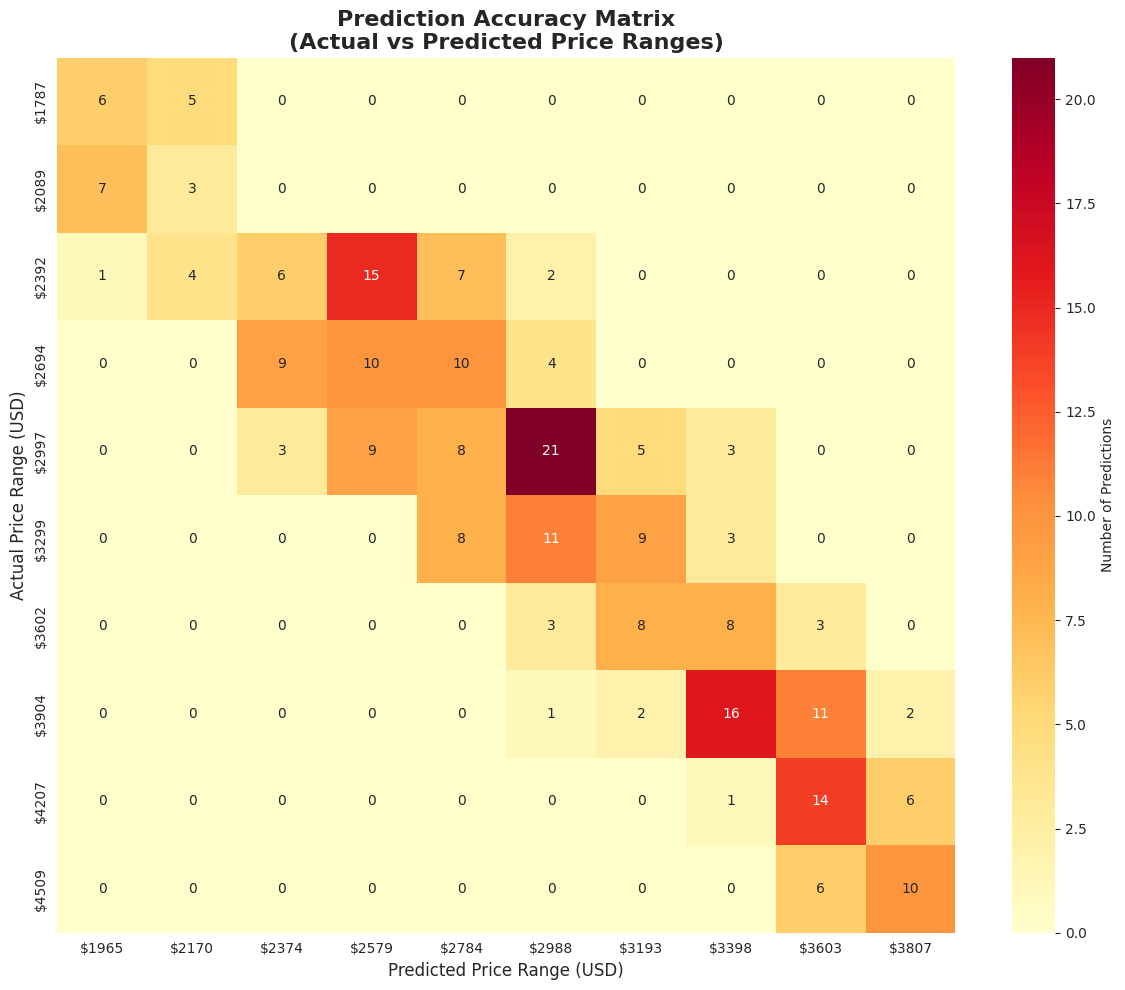


Prediction Error Statistics:
Mean Error: $-246.63
Mean Absolute Error: $328.80
Mean Percentage Error: -6.13%
Mean Absolute Percentage Error: 9.52%


In [34]:
# Visualization 1: Prediction Error Matrix
# Calculate prediction errors
errors = predictions.flatten() - y_test_actual.flatten()
percent_errors = (errors / y_test_actual.flatten()) * 100

# Create bins for actual and predicted prices
n_bins = 10
price_bins = np.linspace(y_test_actual.min(), y_test_actual.max(), n_bins + 1)
pred_bins = np.linspace(predictions.min(), predictions.max(), n_bins + 1)

# Create a 2D histogram (confusion matrix equivalent)
hist_matrix, xedges, yedges = np.histogram2d(
    y_test_actual.flatten(),
    predictions.flatten(),
    bins=[price_bins, pred_bins]
)

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    hist_matrix,
    annot=True,
    fmt='.0f',
    cmap='YlOrRd',
    xticklabels=[f'${int(x)}' for x in pred_bins[:-1]],
    yticklabels=[f'${int(y)}' for y in price_bins[:-1]],
    cbar_kws={'label': 'Number of Predictions'}
)
plt.title('Prediction Accuracy Matrix\n(Actual vs Predicted Price Ranges)',
          fontsize=16, fontweight='bold')
plt.xlabel('Predicted Price Range (USD)', fontsize=12)
plt.ylabel('Actual Price Range (USD)', fontsize=12)
plt.tight_layout()
plt.show()

# Print accuracy statistics
print("\nPrediction Error Statistics:")
print("="*50)
print(f"Mean Error: ${errors.mean():,.2f}")
print(f"Mean Absolute Error: ${np.abs(errors).mean():,.2f}")
print(f"Mean Percentage Error: {percent_errors.mean():.2f}%")
print(f"Mean Absolute Percentage Error: {np.abs(percent_errors).mean():.2f}%")
print("="*50)

In [35]:
# Generate 20-day future predictions
def predict_future_prices(model, data, scaler, n_days=20, seq_length=60):
    """
    Predict future prices using the trained model

    Args:
        model: Trained LSTM model
        data: Historical price data (scaled)
        scaler: MinMaxScaler object used for normalization
        n_days: Number of days to predict into the future
        seq_length: Sequence length used for training

    Returns:
        future_predictions: Array of predicted prices
    """
    # Get the last seq_length days of data
    last_sequence = data[-seq_length:].copy()
    future_predictions = []

    # Predict one day at a time
    for _ in range(n_days):
        # Reshape for prediction
        current_sequence = last_sequence.reshape(1, seq_length, 1)

        # Predict next day
        next_pred = model.predict(current_sequence, verbose=0)

        # Store prediction
        future_predictions.append(next_pred[0, 0])

        # Update sequence: remove first element, add prediction
        last_sequence = np.append(last_sequence[1:], next_pred[0, 0])

    # Convert to array and inverse transform
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)

    return future_predictions

# Predict 20 days into the future
PREDICTION_DAYS = 20
future_prices = predict_future_prices(
    model=model,
    data=scaled_data,
    scaler=scaler,
    n_days=PREDICTION_DAYS,
    seq_length=SEQUENCE_LENGTH
)

# Create future dates
last_date = df['Date'].max()
future_dates = [last_date + timedelta(days=i) for i in range(1, PREDICTION_DAYS + 1)]

# Create DataFrame for future predictions
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_prices.flatten()
})

print(f"\n20-Day Future Price Predictions (after {df['Date'].max().strftime('%Y-%m-%d')}):")
print("="*60)
for i, price in enumerate(future_prices, 1):
    print(f"Day {i:2d}: ${price[0]:,.2f}")
print("="*60)


20-Day Future Price Predictions (after 2022-03-25):
Day  1: $2,813.00
Day  2: $2,843.29
Day  3: $2,863.44
Day  4: $2,873.57
Day  5: $2,875.22
Day  6: $2,870.42
Day  7: $2,861.15
Day  8: $2,849.03
Day  9: $2,835.31
Day 10: $2,820.86
Day 11: $2,806.25
Day 12: $2,791.80
Day 13: $2,777.70
Day 14: $2,764.03
Day 15: $2,750.82
Day 16: $2,738.06
Day 17: $2,725.74
Day 18: $2,713.86
Day 19: $2,702.39
Day 20: $2,691.34


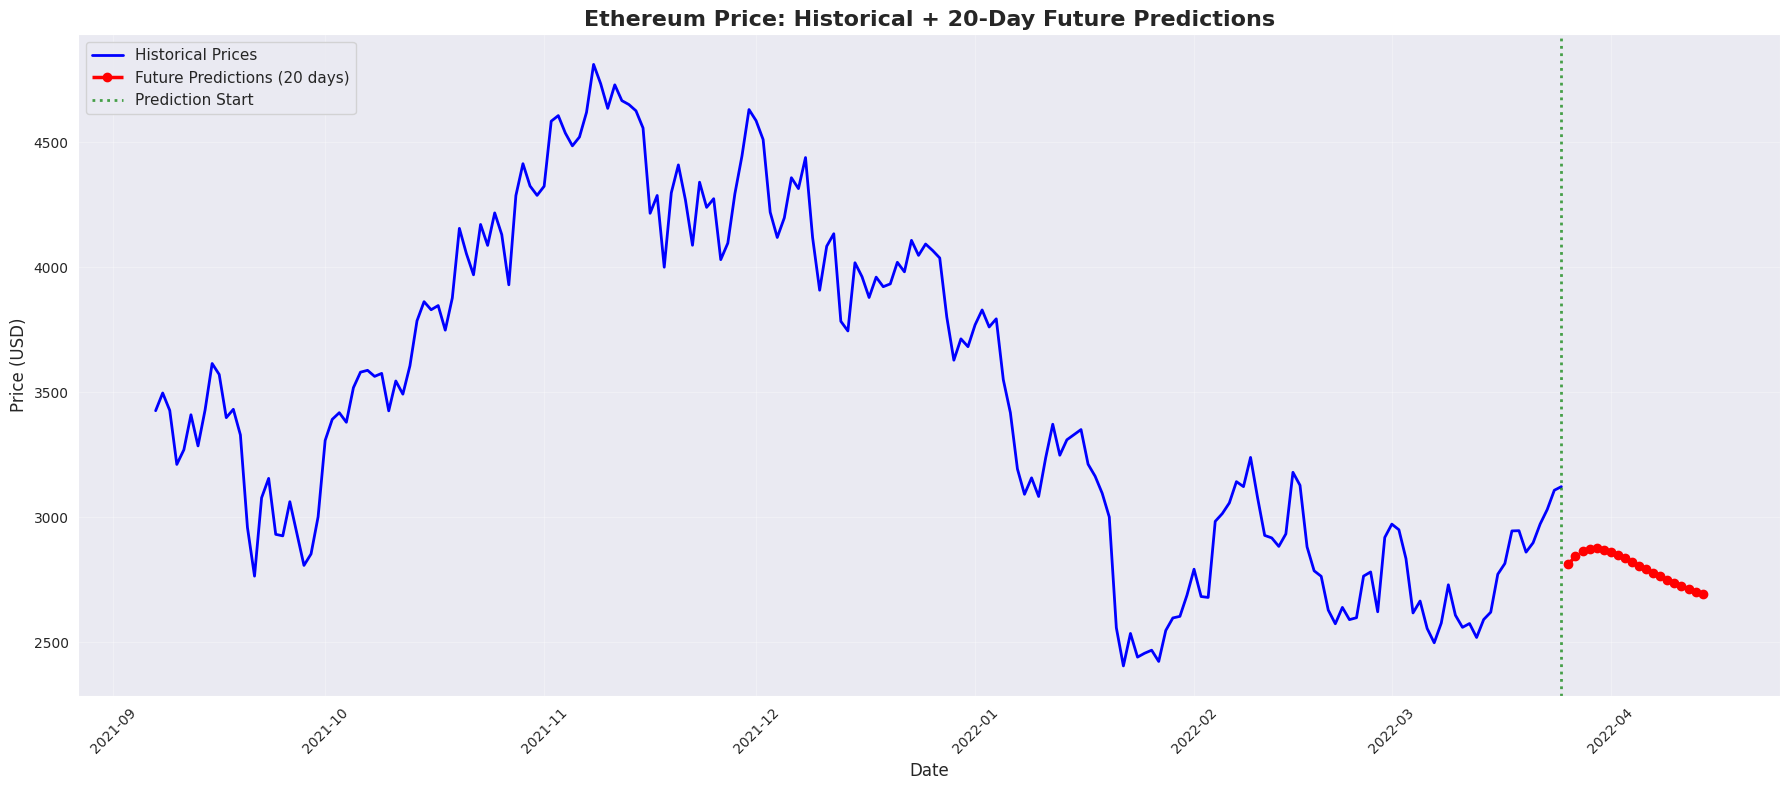

In [36]:
# Visualization 2: Plot 20-Day Future Predictions
plt.figure(figsize=(18, 8))

# Plot last 200 days of historical data
historical_plot = df.tail(200)
plt.plot(historical_plot['Date'], historical_plot['Close'],
         label='Historical Prices', linewidth=2, color='blue')

# Plot future predictions
plt.plot(future_df['Date'], future_df['Predicted_Price'],
         label='Future Predictions (20 days)', linewidth=2.5,
         color='red', marker='o', markersize=6, linestyle='--')

# Add vertical line at prediction start
plt.axvline(x=last_date, color='green', linestyle=':', linewidth=2,
            label='Prediction Start', alpha=0.7)

plt.title('Ethereum Price: Historical + 20-Day Future Predictions',
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()